In [1]:
import os
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications.vgg16 import VGG16 as vg
from keras.applications.vgg16 import preprocess_input
from keras.models import Model,Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout, Input ,Activation,GlobalAveragePooling2D,InputLayer,MaxPool2D
from keras.optimizers import Adam
from PIL import Image
import tensorflow as tf
from keras.regularizers import l2
import matplotlib.pyplot as plt 
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
import seaborn as sns
from sklearn.model_selection import train_test_split
import shutil
from keras.utils import Sequence
from sklearn.model_selection import train_test_split
from keras.activations import relu, softmax
tf.random.set_seed(34)

### Veriyi bölme

```python

import os

num_train_cats = len([i for i in os.listdir(os.path.join('dogs-vs-cats', 'train')) 
                      if i.endswith('.jpg') and i.startswith('cat')])

num_train_dogs = len([i for i in os.listdir(os.path.join('dogs-vs-cats', 'train')) 
                      if i.endswith('.jpg') and i.startswith('dog')])
                            
print(f'Training set cats: {num_train_cats}')
print(f'Training set dogs: {num_train_dogs}')

```

In [3]:
def create_dataframe(img_dir):
    file_paths = []
    labels = []
    for filename in os.listdir(img_dir):
        if filename.endswith('.jpg'):
            file_paths.append(os.path.join(img_dir, filename))
            label = 'cat' if filename.startswith('cat') else 'dog'
            labels.append(label)  

    return pd.DataFrame({'filename': file_paths, 'label': labels})

train_df = create_dataframe('/Users/buketcalp/Downloads/dogs-vs-cats/train')
valid_df = create_dataframe('/Users/buketcalp/Downloads/dogs-vs-cats/valid')
test_df = create_dataframe('/Users/buketcalp/Downloads/dogs-vs-cats/test')

In [4]:
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255)
valid_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='label',
    target_size=(224,224),
batch_size=BATCH_SIZE,
class_mode='binary'
)

valid_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 20000 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


## 2.model

In [6]:
input_tensor = Input(shape=(None, None, 3), name='input_4')


x = Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv1')(input_tensor)
x = Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
x = MaxPooling2D((2, 2), name='block1_pool')(x)


x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
x = MaxPooling2D((2, 2), name='block2_pool')(x)


x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
x = MaxPooling2D((2, 2), name='block3_pool')(x)


x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
x = MaxPooling2D((2, 2), name='block4_pool')(x)

x = GlobalAveragePooling2D(name='global_average_pooling2d')(x)


output_tensor = Dense(1, activation='sigmoid', name='dense_14')(x)


model2 = Model(inputs=input_tensor, outputs=output_tensor, name='model')


model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 32)    896       
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 32)    9248      
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 32)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 64)    18496     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 64)    0     

In [7]:
EPOCHS = 20

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode='min',
    restore_best_weights=True
)


history2 = model2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=EPOCHS,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    callbacks=[early_stopping]  
)

Epoch 1/20
625/625 [==============================] - 288s 461ms/step - loss: 0.6915 - accuracy: 0.5286 - val_loss: 0.6880 - val_accuracy: 0.5657
Epoch 2/20
625/625 [==============================] - 283s 453ms/step - loss: 0.6848 - accuracy: 0.5552 - val_loss: 0.6785 - val_accuracy: 0.5689
Epoch 3/20
625/625 [==============================] - 283s 452ms/step - loss: 0.6807 - accuracy: 0.5652 - val_loss: 0.6745 - val_accuracy: 0.5853
Epoch 4/20
625/625 [==============================] - 286s 457ms/step - loss: 0.6831 - accuracy: 0.5626 - val_loss: 0.6791 - val_accuracy: 0.5990
Epoch 5/20
625/625 [==============================] - 468s 749ms/step - loss: 0.6904 - accuracy: 0.5674 - val_loss: 0.6906 - val_accuracy: 0.5276
Epoch 6/20
625/625 [==============================] - 532s 850ms/step - loss: 0.6810 - accuracy: 0.5628 - val_loss: 0.6765 - val_accuracy: 0.5665
Epoch 7/20
625/625 [==============================] - 526s 842ms/step - loss: 0.6570 - accuracy: 0.6029 - val_loss: 0.6335 -

### Tahmin

In [8]:
test_loss, test_accuracy = model2.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
predictions2 = model2.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)

78/78 [==============================] - 19s 247ms/step - loss: 0.3111 - accuracy: 0.8778
Test Loss: 0.31110578775405884, Test Accuracy: 0.8778044581413269
78/78 [==============================] - 16s 206ms/step


####    Grafik

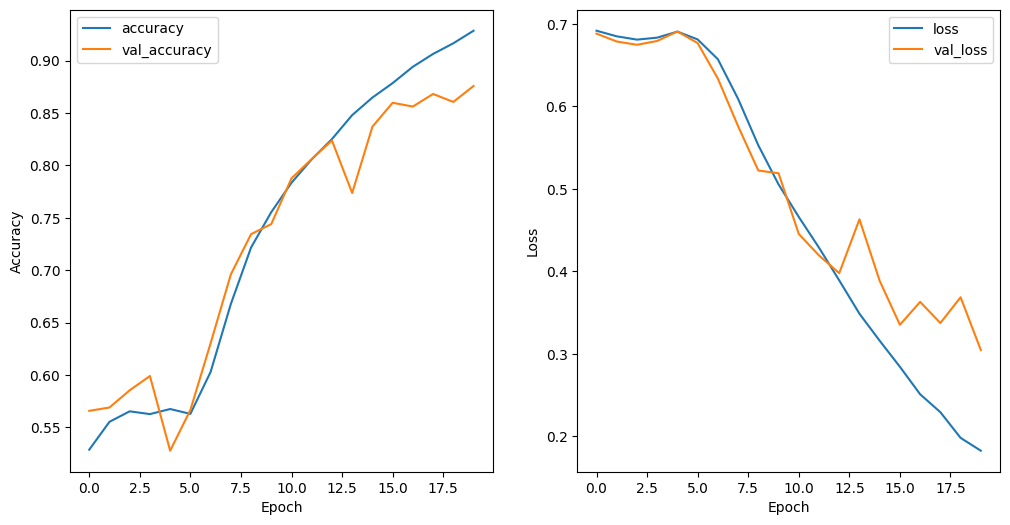

In [9]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='loss')
plt.plot(history2.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Confusion matrix

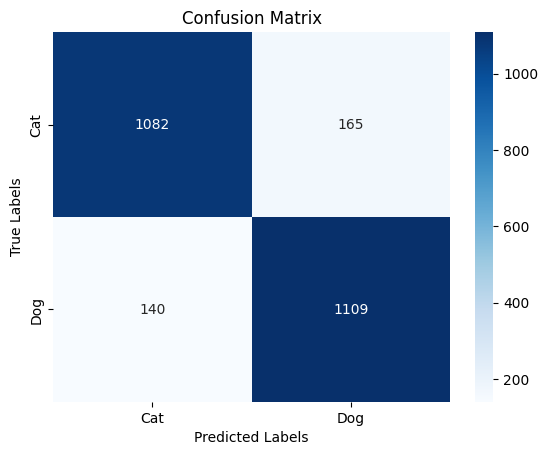

In [11]:
predicted_classes2 = np.where(predictions2 > 0.5, 1, 0).flatten() 
true_classes2 = test_generator.classes
true_classes2 = true_classes2[:len(predicted_classes2)]

conf_matrix2 = confusion_matrix(true_classes2, predicted_classes2)
ax2 = sns.heatmap(conf_matrix2, annot=True, cmap='Blues', fmt='g')

ax2.set_title('Confusion Matrix')
ax2.set_xlabel('Predicted Labels')
ax2.set_ylabel('True Labels')

ax2.xaxis.set_ticklabels(['Cat', 'Dog'])
ax2.yaxis.set_ticklabels(['Cat', 'Dog'])
plt.show()

### Model3

In [ ]:
base_model = vg(weights="imagenet", include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation="sigmoid")(x) 

model3 = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model3.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
EPOCHS = 20

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    mode='min',
    restore_best_weights=True
)


history3 = model3.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=EPOCHS,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    callbacks=[early_stopping]  
)

Epoch 1/20
625/625 [==============================] - 610s 974ms/step - loss: 0.5019 - accuracy: 0.8137 - val_loss: 0.4007 - val_accuracy: 0.8538
Epoch 2/20
625/625 [==============================] - 627s 1s/step - loss: 0.3545 - accuracy: 0.8786 - val_loss: 0.3259 - val_accuracy: 0.8810
Epoch 3/20
625/625 [==============================] - 608s 973ms/step - loss: 0.3032 - accuracy: 0.8923 - val_loss: 0.2906 - val_accuracy: 0.8970
Epoch 4/20
625/625 [==============================] - 637s 1s/step - loss: 0.2753 - accuracy: 0.9002 - val_loss: 0.2705 - val_accuracy: 0.8994
Epoch 5/20
625/625 [==============================] - 654s 1s/step - loss: 0.2570 - accuracy: 0.9067 - val_loss: 0.2557 - val_accuracy: 0.9022
Epoch 6/20
625/625 [==============================] - 709s 1s/step - loss: 0.2437 - accuracy: 0.9079 - val_loss: 0.2449 - val_accuracy: 0.9034
Epoch 7/20
625/625 [==============================] - 691s 1s/step - loss: 0.2337 - accuracy: 0.9116 - val_loss: 0.2374 - val_accuracy: 

### Tahmin

In [ ]:
test_loss, test_accuracy = model3.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
predictions3 = model3.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)

78/78 [==============================] - 50s 643ms/step - loss: 0.1911 - accuracy: 0.9283
Test Loss: 0.1911335438489914, Test Accuracy: 0.9282852411270142
78/78 [==============================] - 59s 767ms/step


### Grafik

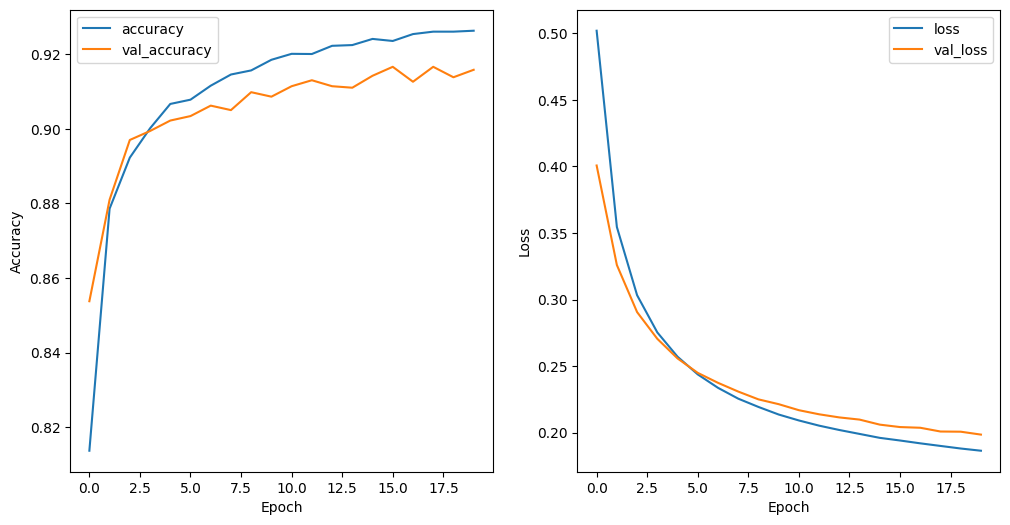

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'], label='accuracy')
plt.plot(history3.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'], label='loss')
plt.plot(history3.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Confusion matrix

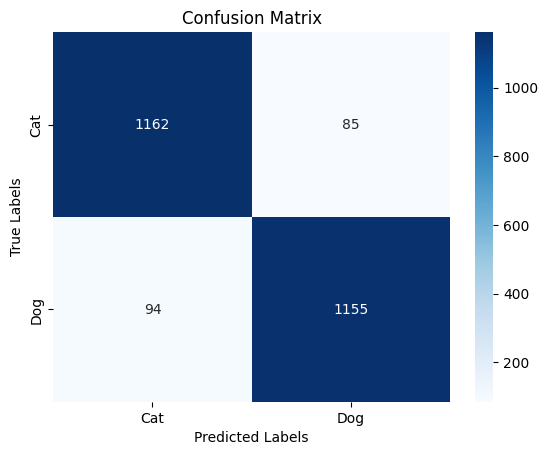

In [ ]:
predicted_classes3 = np.where(predictions3 > 0.5, 1, 0).flatten() 
true_classes3 = test_generator.classes
true_classes3 = true_classes[:len(predicted_classes3)]

conf_matrix3 = confusion_matrix(true_classes3, predicted_classes3)
ax3 = sns.heatmap(conf_matrix3, annot=True, cmap='Blues', fmt='g')

ax3.set_title('Confusion Matrix')
ax3.set_xlabel('Predicted Labels')
ax3.set_ylabel('True Labels')

ax3.xaxis.set_ticklabels(['Cat', 'Dog'])
ax3.yaxis.set_ticklabels(['Cat', 'Dog'])

plt.show()